In [1]:
import scipy.io as si
import numpy as np
import matplotlib.pyplot as plt

#load dataset
File = si.loadmat('ex8data1.mat')

# X contain initial training data
X = File['X']

#Visualize Training Data
plt.plot(X[:,0],X[:,1],'b*')

# Estimate Gaussian

In [2]:
def estimateGaussian(X):
    
    mean = np.zeros((X.shape[1] ,1 )) #easily subtract this mean from Training data
    sigma = np.zeros((X.shape[1],1))#make diagonal matrix for future computation
    
    for i in range(X.shape[1]):
        
        mean[i] = (X[:,i]).mean()
        sigma[i] = ((X[:,i]).std())
    
    return mean.ravel() , (sigma**2).ravel()

mu , sigma_2 = estimateGaussian(X)
print(mu,"  ",sigma_2)

[14.11222578 14.99771051]    [1.83263141 1.70974533]


In [3]:
def multivariateGaussian(X, mu, Sigma2):
    k = len(mu)
    X = X - mu
    Sigma2 = np.diag(Sigma2)
    
    temp = ((2*np.pi)**(-k/2))*(np.linalg.det(Sigma2)**(-.5))
    temp1 = np.exp(-.5*np.sum(np.multiply(X.dot(np.linalg.pinv(Sigma2)),X),1))
    #temp1 = np.exp(-.5*np.sum((np.dot(X,np.linalg.pinv(Sigma2)).dot(X.T)),1))
    
    """using this we get a 307*307 matrix now 
    diagonal elements of this matrix gives probability """
    
    p = temp*temp1
    return p

p = multivariateGaussian(X.copy(), mu, sigma_2.copy())
p[0]

0.06470828501170227

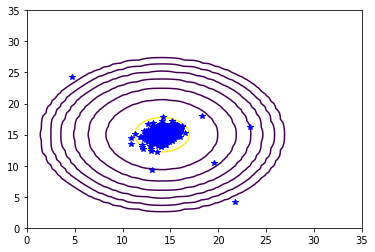

In [77]:
def visualize_fit(X,mu,sigma_2):
    
    #create two 2d arrays
    x = np.arange(0,35.5,.5)
    xx , yy = np.meshgrid(x,x)

    xx = xx.flatten()
    yy = yy.flatten()
    
    #reshape previous 2d arrays in two column arrays
    xx = xx.reshape(len(xx),1)
    yy = yy.reshape(len(yy),1)
    
    #create array to pass it in multivariateGaussian function to compute probability of each point
    test = np.concatenate((xx,yy),axis = 1)
    
    #compute third argument of contour plot
    z = multivariateGaussian(test, mu, sigma_2.copy())

    z = z.reshape(x.shape[0],x.shape[0])
    xx = xx.reshape(x.shape[0],x.shape[0])
    yy = yy.reshape(x.shape[0],x.shape[0])
    
    #select levels
    lev =  np.arange(-20,0,3 , dtype = 'float')
    levels = np.power(10,lev)

    plt.plot(X[:,0],X[:,1],'b*')
    plt.contour(xx,yy,z,levels)

visualize_fit(X,mu,sigma_2.copy())

# Find Outliers

In [60]:
#load cross-validation set
Xval = File['Xval']
yval = File['yval']

#compute probabilities of each example in Cross-Validation Set
pval = multivariateGaussian(Xval.copy(),mu,sigma_2.copy())

def selectThreshold(yval,pval):
    best_ep = 0
    best_F1 = 0
    F1 = 0
    
    stepsize = (pval.max() - pval.min())/1000
    epsilons = np.arange(pval.min(),pval.max() + stepsize,stepsize)
    
    for ep in epsilons:
        classifies = (pval<ep).astype(int)
        
        #compute tp (true positives)
        actual_anomaly = np.where(yval == 1)[0]
        algo_anomaly = np.where(classifies == 1)[0]
        tp = len(np.intersect1d(actual_anomaly,algo_anomaly))
        
        #compute fp (false positives)
        actual_not_anomaly = np.where(yval == 0)[0]
        fp = len(np.intersect1d(actual_not_anomaly,algo_anomaly))
        
        #compute fn (false negatives)
        algo_not_anomaly = np.where(classifies == 0)[0]
        fn = len(np.intersect1d(actual_anomaly,algo_not_anomaly))
        
        #compute precision (give this error for only first case when tp = fp = 0)
        try:
            precision = tp/(tp + fp)
        except ZeroDivisionError:
            precision = 0
        
        #compute recall
        recall = tp/(tp + fn)
        
        #compute F1-Score (give this error for only first case when precison = recall = 0)
        try:
            F1 = (2*precision*recall)/(precision + recall) 
        except ZeroDivisionError:
            F1 = 0
        
        if (F1 > best_F1):
            best_F1 = F1
            best_ep = ep
            
    return best_ep , best_F1

#compute Epsilon and F1 score
epsilon , F1 = selectThreshold(yval, pval)
print('Epsilon : ' , epsilon , "  F1-Score " , F1)

Epsilon :  8.990852779269493e-05   F1-Score  0.8750000000000001


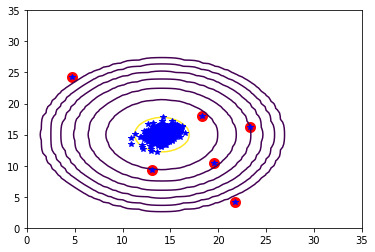

In [87]:
#find outliers
outliers = X[np.where(p<epsilon)]

visualize_fit(X,mu,sigma_2.copy())
plt.scatter(outliers[:,0],outliers[:,1],edgecolors='red',linewidths=5)
plt.show()

# High Dimension Data-Set

In [93]:
#load Dataset
File_2 = si.loadmat('ex8data2.mat')

X_high = File_2['X']
Xval_high = File_2['Xval']
yval_high = File_2['yval']

#estimate Gaussian
mu_high , sigma_2_high = estimateGaussian(X_high)

#get probabilities of each Training example using multivariateGaussian
p_high = multivariateGaussian(X_high.copy(),mu_high,sigma_2_high.copy())

#get probabilities of each Cross-Validation example using multivariateGaussian
pval_high = multivariateGaussian(Xval_high.copy(),mu_high,sigma_2_high.copy())

#Find epsilon and F1-Score 
epsilon_high , F1_high = selectThreshold(yval_high,pval_high)
print('Epsilon : ' , epsilon_high , "  F1-Score " , F1_high)

outliers_high = X_high[np.where(p_high<epsilon_high)]
print('Outliers found: ', len(outliers_high))

Epsilon :  1.3772288907613575e-18   F1-Score  0.6153846153846154
Outliers found:  117
